# Word Embeddings

In [66]:
import numpy as np
import pandas as pd
from ast import literal_eval
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import unicodedata
import string

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/abdala9512/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdala9512/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def process_text(text,  keep_as_list = False):
    '''
    Input:
        text: a string containing a text
    Output:
        text_clean: a list of words containing the processed text

    '''
    stemmer = SnowballStemmer('spanish')
    stopwords_ = stopwords.words('spanish')
    text_tokens = word_tokenize(text)

    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_ and  # remove stopwords
                word not in string.punctuation and 
            word.isalpha()):  # remove punctuation
            #stemmed_word = stemmer.stem(word)
            text_clean.append(word)
    if keep_as_list:
        return text_clean
    return ' '.join(text_cleaan)


def remove_accent(text: str):
    
    unaccented_text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return unaccented_text

def basic_cleaning(dataframe: pd.DataFrame, text_cols: list = None):
    
    # Strip text
    for col in dataframe.select_dtypes("object").columns:
        dataframe[col] = dataframe[col].str.strip()
        dataframe[col] = dataframe[col].str.lower()
    
    # Remove tildes
    if text_cols:
        for col in dataframe[text_cols].columns:
            dataframe[col] = dataframe[col].apply(lambda x: remove_accent(str(x)))
    return dataframe


In [147]:
data = pd.read_csv("../../data/ArchivoProblemas_ajustado.csv", sep=";")
data.drop("Unnamed: 4", axis=1, inplace=True)
data.dropna(inplace=True)
data["DESCRIPCION_LEM"] = data["DESCRIPCION_LEM"].apply(lambda x: " ".join(literal_eval(x)))

In [148]:
data = basic_cleaning(data, text_cols=["DESCRIPCION_LEM"])
data["text_tokenized"] = data["DESCRIPCION_LEM"].apply(lambda x: process_text(x, keep_as_list=True))
data

,TIPO,ID,DESCRIPCION,DESCRIPCION_LEM,text_tokenized
0,problem,3655.0,"deficiencia en las reglas, protocolos y proces...","deficiencia en el regla , protocolo y proceso ...","[deficiencia, regla, protocolo, proceso, corre..."
1,effect,18181.0,descoordinacion institucional en el tema de at...,descoordinacion institucional en el tema de at...,"[descoordinacion, institucional, tema, atencio..."
2,effect,18182.0,ineficiencia e ineficacia en la atencion a vic...,ineficiencia e ineficacia en el atencion a vic...,"[ineficiencia, ineficacia, atencion, victima, ..."
3,effect,18183.0,inequidad social,inequidad social,"[inequidad, social]"
4,effect,18626.0,baja capacidad de las entidades territoriales ...,bajo capacidad de el entidad territorial imple...,"[bajo, capacidad, entidad, territorial, implem..."
...,...,...,...,...,...
13029,cause,2939.0,requerimientos legales sin cumplir,requerimiento legal sin cumplir,"[requerimiento, legal, cumplir]"
13030,cause,2940.0,el funcionamiento de la universidad no esta ga...,el funcionamiento de el universidad no este ga...,"[funcionamiento, universidad, garantizar]"
13031,cause,2941.0,poca gestion institucional dentro de los proce...,poco gestion institucional dentro de el proces...,"[gestion, institucional, dentro, proceso, aten..."
13032,cause,2942.0,eficit de recursos economicos y financieros,eficit de recurso economico y financiero,"[eficit, recurso, economico, financiero]"


# Embeddings

In [145]:
"""Emedding visualizacion Tool"""

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from typing import Any

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

MOST_COMMON_ALL = 300
word_to_cat = {}
for category in ["problem", "cause", "effect"]:
    words = Counter(
        [word for sublist in data[data["TIPO"] == category]["text_tokenized"] 
         for word in sublist 
        ]).most_common(MOST_COMMON_ALL)
    for i in range(MOST_COMMON_ALL):
        key_ = words[i][0]
        if  key_ not in word_to_cat:
            word_to_cat[words[i][0]] = category, words[i][1]
        else:
            if word_to_cat[words[i][0]][1] > words[i][1]:
                word_to_cat[words[i][0]] = category, words[i][1]
            else:
                continue
word_to_cat  = {key: value[0] for key, value in word_to_cat.items()}    

def visualize_embedding(
    key_to_vector_embedding: dict, 
    algorithm: Any, 
    word_limit: int = 20) -> None:
    """Crea una visualizacion de embeddings
    """
    assert (
        isinstance(algorithm, PCA) or 
        isinstance(algorithm, TSNE) or
        isinstance(algorithm, UMAP)
    ), "La visualizacion solo funciona con instancias PCA, TSNE o UMAP"
    
    vectors = []
    labels = []
    for key, vector in key_to_vector_embedding.items():
        vectors.append(vector)
        labels.append(key)
        
    reduced_2d_data = algorithm.fit_transform(np.array(vectors))
    x, y =  reduced_2d_data[:, 0], reduced_2d_data[:, 1]
    
    for i in range(word_limit):
        if labels[i] not in word_to_cat.keys():
            continue
        type_ = word_to_cat[labels[i]]
        color = np.where(type_ == "problem", '#0D4C92',
                np.where(type_ == "cause", '#0E5E6F', '#BCEAD5')
        )
        plt.scatter(x[i],y[i], color=str(color), label = type_)
        plt.annotate(
            labels[i],
            xy=(x[i], y[i]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
        )
    plt.xlabel("Dim 1", size=15)
    plt.ylabel("Dim 2", size=15)
    plt.title("Representación Word Embeddings - SkipGrams",size=30)
    plt.grid(color='#EFF5F5')
    plt.legend(["problem", "cause", "effect"], bbox_to_anchor=(1.01, 1.01), loc='upper left')



# Ejemplo Viz. Embedding

In [143]:
from gensim.models import Word2Vec

sentences = [word for word in data["text_tokenized"]]
embedding_word2vec = Word2Vec(sentences=sentences, min_count=1,vector_size=100)
embedding_word2vec=Word2Vec(sentences=sentences,
                            sg=1, 
                            vector_size=10, 
                            window=5,
                            min_count=5,
                            negative=15,
                            seed=123
                           )
vocab_ = list(embedding_word2vec.wv.key_to_index.keys())
key_to_vector_embedding = { word: embedding_word2vec.wv[word] for word in vocab_ }

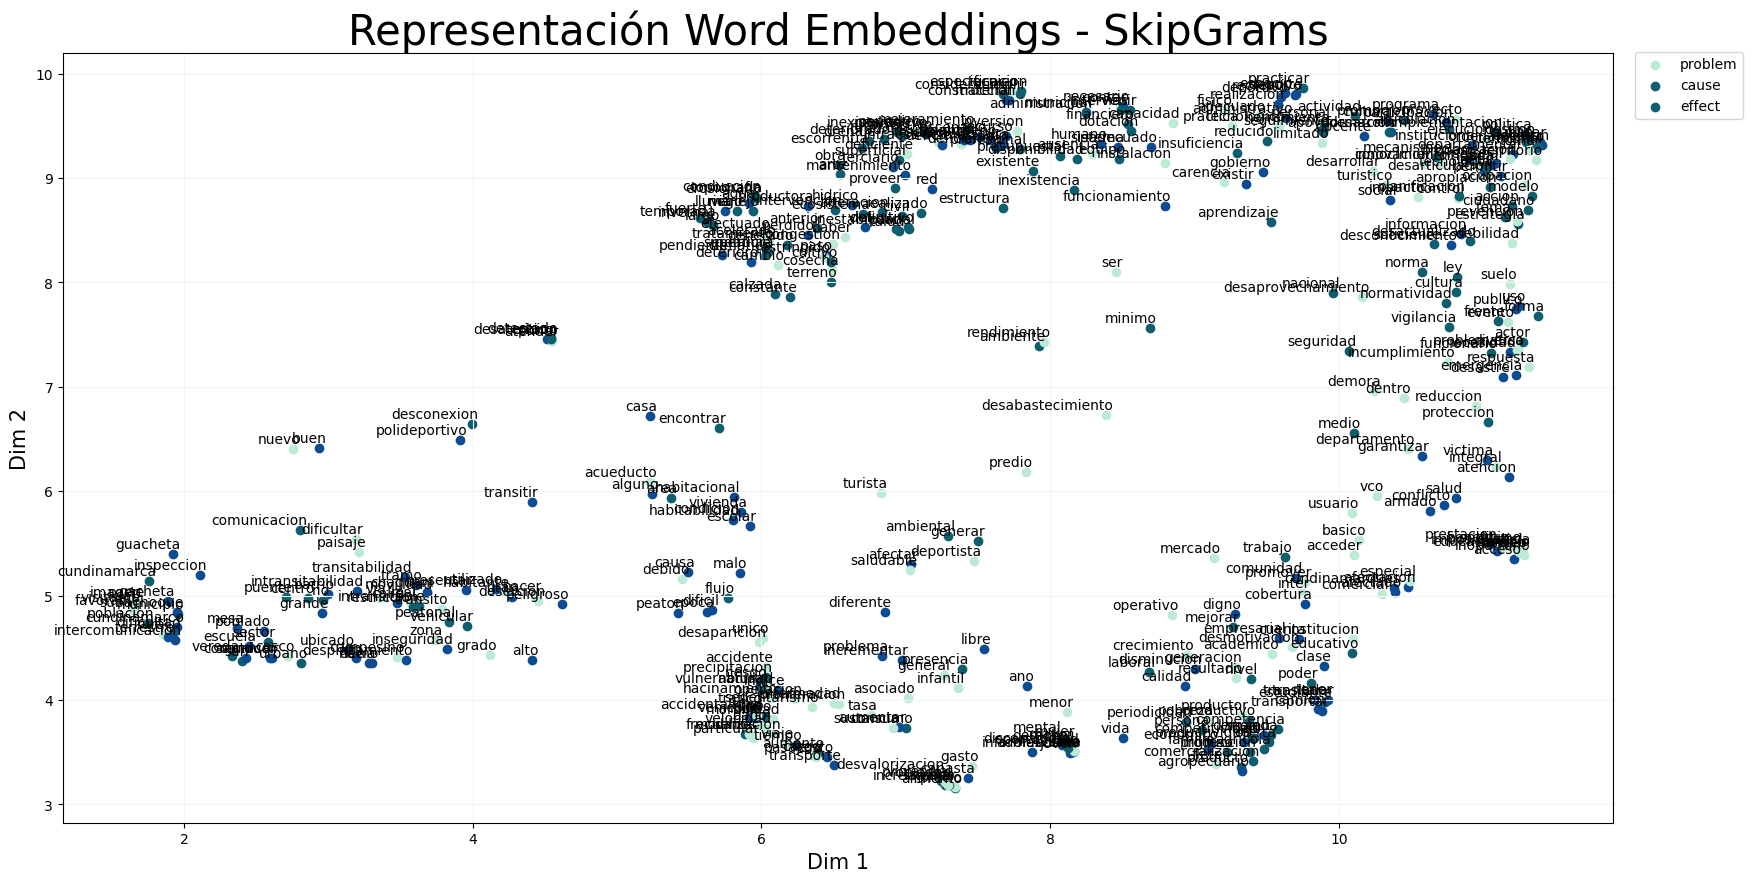

In [146]:
visualize_embedding(key_to_vector_embedding = key_to_vector_embedding, algorithm=UMAP(), word_limit=500)